In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os

In [2]:
def read_trace_file(f):
    trace = []

    for line in f:
        trace.append(float(line[:-1]))

    return trace

traces = []

directory    = "ELMO/output/traces/"
lst          = os.listdir(directory) # your directory path
num_traces   = len(lst)
                   

for i in tqdm.trange(1, num_traces + 1):
    f     = open(directory + "trace" + f'{str(i):0>5}' + ".trc", "r")
    trace = read_trace_file(f)
    
    traces.append(trace)
    f.close()

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:31<00:00, 36.77it/s]


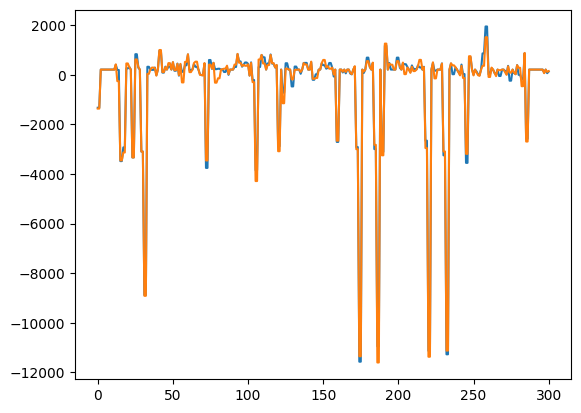

In [3]:
plt.plot(traces[0])
plt.plot(traces[1])

In [4]:
print(len(traces[0]))

301


In [5]:
def evaluate_corr(traces,hyp_pwr):
    
    num_samples    = np.shape(traces)[1]
    traces_hyp_pwr = np.concatenate((traces,hyp_pwr),axis=1)
    corr_matrix    = np.corrcoef(traces_hyp_pwr.T)
    
    return corr_matrix[num_samples,0:num_samples]

10000
10000
10000
10000
10000
10000
10000
10000


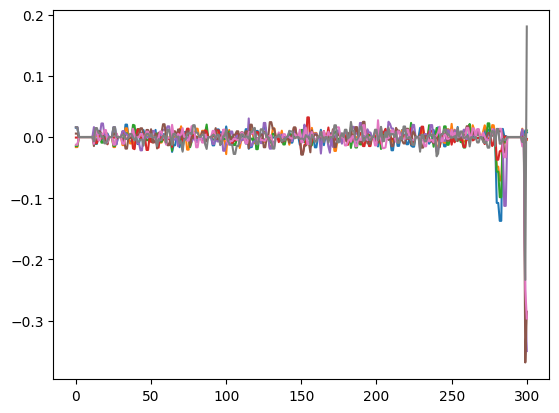

In [6]:
outputfile = 'ELMO/output/output.txt'

f = open(outputfile, "r")
lines = f.readlines()

for byte_position in range(8):
    outputs = []
    count   = 0
    for line in lines:
        count = count + 1
        if (count % 5 == 0):
            #print(line[:-1].split(' '))
            outputs.append(int((line[:-1].split(' ')[byte_position]), 16))

    print(len(outputs))

    plt.plot(evaluate_corr(np.array(traces[0:num_traces]),np.array(outputs[0:num_traces]).reshape(-1,1)))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 52649.67it/s]


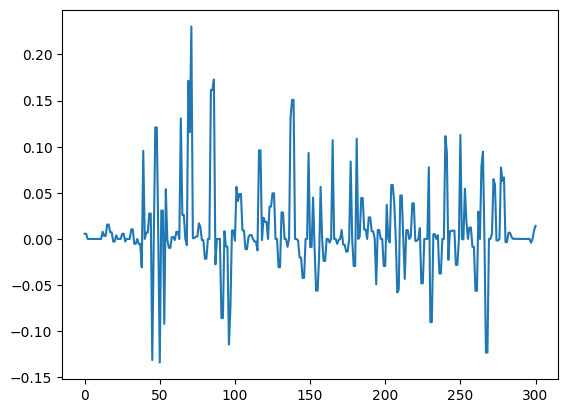

In [7]:
# set byte in 64-bit Ascon word
def set_byte(b, i):
    return (b) << (56 - 8 * (i))

# load bytes into 64-bit Ascon word
def load_bytes(byte_array, n):
    x = 0
    for i in range(n):
        x |= set_byte(byte_array[i], i)
    return x

def ROR(x, n):
    return x >> n | x << (-n & 63);

def HW(x):
    return bin(x)[2:].count('1')

def ascon_first_round(S, C):
    
    T    = [0] * 5
    
    # addition of round constant
    S[2] ^= C
    
    # substitution layer
    S[0] ^= S[4]
    S[4] ^= S[3]
    S[2] ^= S[1]
    
    SBox_in = copy.deepcopy(S)
    
    # start of keccak s-box
    T[0] = S[0] ^ (~S[1] & S[2])
    T[1] = S[1] ^ (~S[2] & S[3])
    T[2] = S[2] ^ (~S[3] & S[4])
    T[3] = S[3] ^ (~S[4] & S[0])
    T[4] = S[4] ^ (~S[0] & S[1])
    
    SBox_out = copy.deepcopy(T)
    
    # end of keccak s-box
    T[1] ^= T[0]
    T[0] ^= T[4]
    T[3] ^= T[2]
    T[2] = ~T[2]
    
    # linear diffusion layer
    S[0] = T[0] ^ ROR(T[0], 19) ^ ROR(T[0], 28);
    S[1] = T[1] ^ ROR(T[1], 61) ^ ROR(T[1], 39);
    S[2] = T[2] ^ ROR(T[2], 1)  ^ ROR(T[2], 6);
    S[3] = T[3] ^ ROR(T[3], 10) ^ ROR(T[3], 17);
    S[4] = T[4] ^ ROR(T[4], 7)  ^ ROR(T[4], 41);

    return S, SBox_in, SBox_out

def state_to_int320(state):
    state_int320 = ((state[0] & (2**64-1)) << 4*64) | \
                   ((state[1] & (2**64-1)) << 3*64) | \
                   ((state[2] & (2**64-1)) << 2*64) | \
                   ((state[3] & (2**64-1)) << 1*64) | \
                   ((state[4] & (2**64-1)) << 0)

    return state_int320

def bit_to_int(bit_array):
    x = 0
    for i in range(5):
        x |= (bit_array[i] << (5 - i))
        
    return x

# Open input file
f        = open("ELMO/output/randdata.txt", "r");
lines    = f.readlines()
line_num = 0

k0 = [0] * 8
k1 = [0] * 8

for i in range(8):
    k0[i] = int(lines[line_num].strip('\n'), 16)
    line_num += 1
    k1[i] = int(lines[line_num].strip('\n'), 16)
    line_num += 1
    
K0 = load_bytes(k0, 8)
K1 = load_bytes(k1, 8)

ASCON_128_KEYBYTES  = 16
ASCON_128_RATE      = 8
ASCON_128_PA_ROUNDS = 12
ASCON_128_PB_ROUNDS = 6

ASCON_128_IV = ((ASCON_128_KEYBYTES * 8) << 56) | \
               ((ASCON_128_RATE * 8)     << 48) | \
               ((ASCON_128_PA_ROUNDS)    << 40) | \
               ((ASCON_128_PB_ROUNDS)    << 32)

HW_SBox_in_all  = []
HW_SBox_out_all = []
HW_State_out_all = []

num_traces = 10000

for i in tqdm.trange(num_traces):
    
    n0 = [0] * 8
    n1 = [0] * 8
    
    for j in range(8):
        n0[j] = int(lines[line_num].strip('\n'), 16)
        line_num += 1
        n1[j] = int(lines[line_num].strip('\n'), 16)
        line_num += 1

    N0 = load_bytes(n0, 8)
    N1 = load_bytes(n1, 8)
    
    S    = [0] * 5
    S[0] = ASCON_128_IV + 0
    S[1] = K0 + 0
    S[2] = K1 + 0
    S[3] = N0 + 0
    S[4] = N1 + 0

    S, SBox_in, SBox_out = ascon_first_round(S, int('0xf0', 16))
    
    for j in range(5):
        buffer = [0] * 8
        for k in range(8):
            buffer[k] = (S[j] >> (k * 8)) & 255
        
#             print(hex(buffer[k])[2:])
        
    HW_SBox_in_all.append(HW(bit_to_int([SBox_in[i] & 1 for i in range(5)])))
#     HW_SBox_out_all.append(HW(bit_to_int(SBox_out)))
#     HW_State_out_all.append(HW(bit_to_int(S)))
    
plt.plot(evaluate_corr(np.array(traces[0:num_traces]),np.array(HW_SBox_in_all[0:num_traces]).reshape(-1,1)))